# Deep Neural Network Ensembles

This chapter considers the method of 'bagging' for deep neural network predictions. Insead of a single hypothesis, we create hypotheses $h_{1},h_{2},\dots h_{n}$ and form an ensemble prediction. For regression tasks the final prediction of the ensemble could be the mean and for classification the mode. The idea of bagging is to form a moderate learner out of several weak learners. An important property is that the final learner is improved the more uncorrelated the single weak learners are. The idea of bagging goes back to `cite`{Breiman1996} and is a shorthand for bootstrap-aggregation, indicating the two important steps bootstrapping and aggregating

In [8]:
import torch
from torch.nn import Sequential
import numpy as np
from sklearn.datasets import load_wine, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.stats import mode

In [2]:
SEED = 123
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float64)
rng = np.random.default_rng(SEED)
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (5, 3)

In the following we will use the wine datasetfor classification tasks and the california housing data set for regression tasks.
The training and test data for the california housing dataset will be standardized to enhance learning since we will use only small models with limited capacity.

In [10]:
X_wine, y_wine = load_wine(return_X_y = True)
X_diabetes, y_diabetes = load_diabetes(return_X_y = True)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine,
                                                                        test_size=1,
                                                                        random_state = SEED)


X_train_housing, X_test_housing, y_train_housing, y_test_housing = train_test_split(*fetch_california_housing(return_X_y=True),
                                                                                    test_size=1)
scaler = StandardScaler()
X_train_housing = scaler.fit_transform(X_train_housing)
X_test_housing = scaler.transform(X_test_housing)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(X_diabetes, y_diabetes,
                                                                                        test_size = 1,
                                                                                        random_state = SEED)

Let us first create some useful functions to make the training and creation of an ensemble a bit more handy and hopefully less cluttered. We write functions that initialize some random fully connected architecture in `nn_layers_factory` which is used to create a fully connected neural network class with `instantiate_nn`. Since `nn_layers_factory` just created the hidden layer we need to take some adjustments to account for the size of input features and the output using the function `nn_factory`.

In [72]:
def set_neurons(neurons):
    """
    Creates an ascendeng.descendig order of #neurons per layer.
    """
    neurons.sort()
    lower_half, upper_half = neurons[neurons < np.median(neurons)], neurons[neurons >= np.median(neurons)]
    #reverse order
    upper_half = upper_half[::-1]
    return np.concatenate([lower_half, upper_half])

In [47]:
def nn_layers_factory(layers_min = 4, layers_max = 10, neurons_min = 3, neurons_max = 25):
    """
    Create a DNN architecture with random number of neurons and layers.
    """
    
    n_layers = np.random.randint(layers_min,layers_max)
    neurons = np.random.randint(neurons_min,neurons_max,n_layers)
    # reorganise such that architecture expands and decreases
    neurons = set_neurons(neurons)
    # lambda expression needed to enforce direct evaluation
    layers = [torch.nn.Linear(neurons[(lambda x: x)(idx)], neurons[(lambda x: x + 1)(idx)]) for idx in range(len(neurons)-1)]
    layers = {f"layer_{idx+1}": layers[idx] for idx in range(len(layers))}
    activations = [torch.nn.ReLU()] * len(layers)
    activations = {f"activation_{idx+1}": activations[idx] for idx in range(len(activations))}
    names = [name for pair in zip(list(layers.keys()), list(activations.keys())) for name in pair]
    components = [value for pair in  zip(list(layers.values()), list(activations.values())) for value in pair]
    net = torch.nn.Sequential()

    for component, name  in zip(components, names):
        net.add_module(name, component)

    return net

In [48]:
def nn_factory(n_features: int, n_output: int, classification = True) -> Sequential:
    """
    Call nn_layer_factory to create random architecture and adjust for input and output.
    """
    
    net = nn_layers_factory()
    # adjustment for input and output
    first_layer = net[0]
    last_layer = net[-2]
    last_activation = net[-1]
    if classification:
        adjusted_last_activation = torch.nn.Softmax(dim=1)
    else:
        adjusted_last_activation = last_activation
        
    adjusted_first_layer = torch.nn.Linear(n_features, first_layer.out_features)
    adjusted_last_layer = torch.nn.Linear(last_layer.in_features, n_output, bias = False)
    
    # put it all together
    net[0] = adjusted_first_layer
    net[-1] = adjusted_last_activation
    net[-2] = adjusted_last_layer

    return net[0:-1]

In [49]:
def instantiate_nn(architecture):
    """
    Instantiate DNN model from adjusted architecture.
    """
    class CustomNet(torch.nn.Module):
        def __init__(self, architecture):
            super(CustomNet, self).__init__()
            self.seq_model = architecture
    
        def forward(self, x):
            return self.seq_model(x)
    net = CustomNet(architecture)
    return net

In [238]:
def train_model(nn, X_train, y_train, classification = True, n_epochs = 800, bootstrap = True, boot_size = 0.75):
    """
    Train a singe DNN.
    """

    # create boostrap sample
    if bootstrap:
        assert boot_size > 0 and boot_size < 1
        idx = np.arange(X_train.shape[0])
        n_boot = int(np.ceil(int(boot_size * len(idx))))
        idx_boot = np.random.choice(idx, size = n_boot, replace=False)
        X_train = X_train[idx_boot]
        y_train = y_train[idx_boot]

    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    
    learning_rate = 0.001
    
    if classification:
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.MSELoss()
        y_train = y_train.unsqueeze(1)
        
    optimizer = torch.optim.Adam(nn.parameters(), lr=learning_rate)

    # train for n_epochs
    acc_loss = []
    for epoch in range(n_epochs):
        nn.train()
    
        # Forward pass
        outputs = nn(X_train)
        loss = criterion(outputs, y_train)
        acc_loss.append(loss.detach().item())
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return acc_loss

In [143]:
def create_model_ensemble(X_train, n_outputs, n_models = 20):
    """
    Create list of DNN models.
    """
    
    ensemble = list()
    n_features = X_train.shape[1]
    print(f"Create ensemble of {n_models} models with {n_features} features and {n_outputs} outputs.")
    
    for idx in range(n_models):
        model_architecture = (lambda x: x) (nn_factory(n_features, n_outputs))
        model_class = (lambda x: x) (instantiate_nn(model_architecture))
        ensemble.append(model_class)
    return ensemble

Below we create some functions for training, testing and plotting of our results:

In [127]:
def train_ensemble(ensemble, X_train, y_train, classification = True, n_epochs = 250, bootstrap = True, boot_size = 0.75):
    """
    Train the ensemble.
    """
    
    trained_ensemble = list()
    losses = list()
    for model in ensemble:
        if classification:
            loss = (lambda x: x)(train_model(model, X_train, y_train, True, n_epochs, bootstrap, boot_size))
        else:
            loss = (lambda x: x)(train_model(model, X_train, y_train, False, n_epochs, bootstrap, boot_size))
        losses.append(loss)
    return losses

In [96]:
def predict_model(model, X_test, classification = True):
    X_test = torch.from_numpy(X_test)
    model.eval()
    with torch.no_grad():
        pred = model(X_test).numpy()
        if classification:
           pred = pred.argmax(axis = 1)
    return pred

def get_ensemble_predictions(trained_ensemble, X_test, classification = True):
    predictions = list()
    for model in trained_ensemble:
        model_pred = predict_model(model, X_test, classification)
        predictions.append(model_pred)
    predictions = np.concatenate(predictions, axis = 0)
    return predictions

In [249]:
def plot_ensemble(losses, predictions, y_test, classification = True, xlab = None, ylab = None, title = None):

    if classification:
        if xlab is None:
            xlab = "Classes"
        if ylab is None:
            ylab = "Counts"
        if title is None:
            title = f"Result of {len(predictions)} predictions on Classification Task (true class: {y_test_wine.item()})"
    
        unique_values, counts = np.unique(predictions, return_counts=True)
        predicted_classes =  pd.DataFrame({"Classes": unique_values,"Counts": counts})

        # get relative frequencies:
        plt.bar(predicted_classes["Classes"].astype(str), predicted_classes["Counts"])
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)
        
    else:

        # calculate std:
        std = np.std(predictions)
        # calculate mean
        mu = np.mean(predictions)
        # calculate variation coefficient
        cv = std / mu
        
        if xlab is None:
            xlab = "x"
        if ylab is None:
            ylab = "$\hat{y}=f(x)$"
        if title is None:
            title = "Result of preds predictions on Regression Task\n$\hat{\sigma}=std$, CV=varcoef, $\hat{\mu}=armean$, $y_{query}=y_true$"
            title = title.replace("preds", str(int(len(predictions))))
            title = title.replace("std", str(np.round(std, 2)))
            title = title.replace("varcoef", str(np.round(cv, 2)))
            title = title.replace("armean", str(np.round(mu, 2)))
            title = title.replace("y_true", str(np.round(y_test.item(), 2)))
            
     
        plt.hist(predictions)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)

Now let us consider different cases. We can create several different models and train each on a bootstrapped sample of the training data (case I) or on the data as it is (case II) or use jus one model but train it on bootstrapped datasets. The idea is that by using only a boostrapped sample of the original data we can hopefully capture different apects of the data. In fact one can show that the less correlated the bootstrapped samples are, the lower the variance.
For a graphical assesment of our results we plot the predicted classes for the classification task and for the regression task on the housing dataset we will plot a histogram and in addition state the mean predicted value, the variance and the coefficient of variation (the ratio of variance relative to mean). The lower the variance the less 'disagreement' we have between our different hypotheses. Our aim is to asses the uncertainty associated with the prediction of the test datapoints.

By default we will use a bootstrap size of 75%, that is we will sample 75% out of the training data and we will use for ensembles 50 models in total:

In [100]:
n_models = 25

### Experiment I (model ensemble and bootstrap)

Let us first fit a ensemble of different models on bootstrapped data:

In [144]:
ensemble_wine = create_model_ensemble(X_train_wine, n_outputs = 3, n_models = n_models)

Create ensemble of 25 models with 13 features and 3 outputs.


In [145]:
ensemble_housing = create_model_ensemble(X_train_housing, n_outputs = 1, n_models = n_models)

Create ensemble of 25 models with 8 features and 1 outputs.


In [146]:
losses_housing = train_ensemble(ensemble_housing, X_train_housing, y_train_housing, n_epochs = 150, classification = False)

In [147]:
losses_wine = train_ensemble(ensemble_wine, X_train_wine, y_train_wine, n_epochs = 80, classification = True)

In [148]:
predictions_wine = get_ensemble_predictions(ensemble_wine, X_test_wine, classification = True)
predictions_housing = get_ensemble_predictions(ensemble_housing, X_test_housing, classification = False).squeeze()

We can visualize the learning development of each model by plotting the loss for each model agains each epoch:

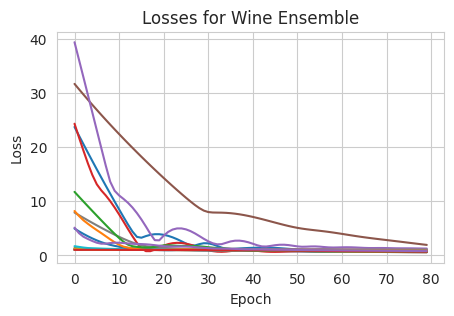

In [151]:
_ = pd.DataFrame(losses_wine).transpose().plot(legend = False, xlabel = "Epoch", ylabel = "Loss", title = "Losses for Wine Ensemble")

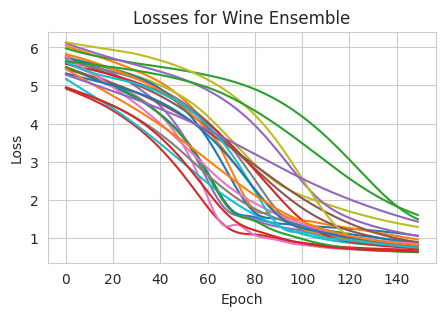

In [150]:
_ = pd.DataFrame(losses_housing).transpose().plot(legend = False, xlabel = "Epoch", ylabel = "Loss", title = "Losses for Housing Ensemble")

For the wine dataset losses seem to converge relatively quickly whereas for the regression task the models seem tohave a larger variety in terms of losses but also seem to converge. Now let us look at the actual predictions:

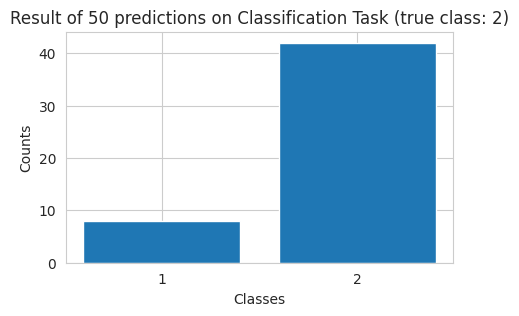

In [63]:
plot_ensemble(losses_wine, predictions_wine, y_test_wine, classification = True)

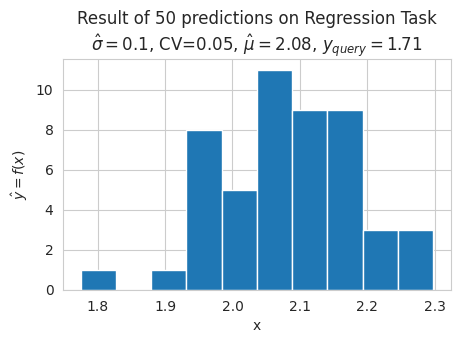

In [64]:
plot_ensemble(losses_housing, predictions_housing, y_test_housing, classification = False)

### Experiment II (model ensemble and no bootstrap)

In [214]:
losses_housing = train_ensemble(ensemble_housing, X_train_housing, y_train_housing, n_epochs = 120, classification = False, bootstrap = False)

In [218]:
losses_wine = train_ensemble(ensemble_wine, X_train_wine, y_train_wine, n_epochs = 100, classification = True, bootstrap = False)

Now let us look at the ensemble losses again:

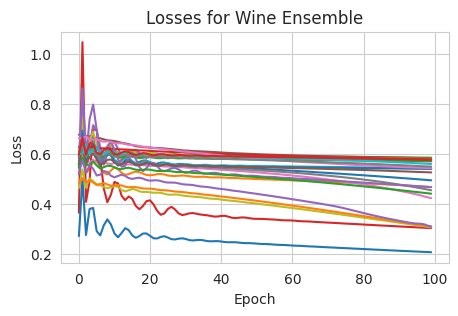

In [219]:
_ = pd.DataFrame(losses_wine).transpose().plot(legend = False, xlabel = "Epoch", ylabel = "Loss", title = "Losses for Wine Ensemble")

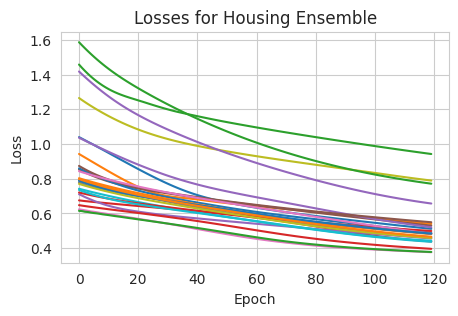

In [156]:
_ = pd.DataFrame(losses_housing).transpose().plot(legend = False, xlabel = "Epoch", ylabel = "Loss", title = "Losses for Housing Ensemble")

Note the different scale on the y-axis: Aparrently it wwould have been better without bootstrapping the data. But how about predictions?

In [213]:
predictions_wine = get_ensemble_predictions(ensemble_wine, X_test_wine, classification = True)
predictions_housing = get_ensemble_predictions(ensemble_housing, X_test_housing, classification = False).squeeze()

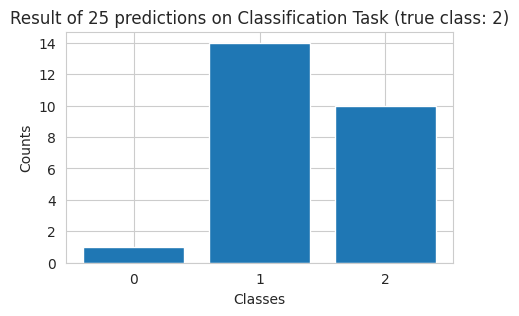

In [220]:
plot_ensemble(losses_wine, predictions_wine, y_test_wine, classification = True)

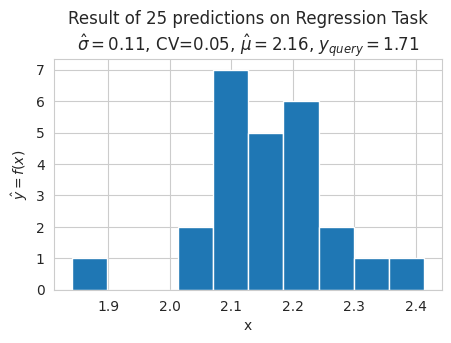

In [221]:
plot_ensemble(losses_housing, predictions_housing, y_test_housing, classification = False)

### Experiment III (single model and bootstrap)

Now, instead of considering an ensemble of models let us fix one model for each regression or classification task and train on bootstrapped data. Again we use 75% of the sample to be bootstrapped and we will create 50 'data-bootstrapped' samples for each task:

In [230]:
n_boots = 50

In [222]:
class HousingModel(torch.nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        self.fc1 = torch.nn.Linear(X_train_housing.shape[1], 40)
        self.fc2 = torch.nn.Linear(40, 30)
        self.fc3 = torch.nn.Linear(30, 10)
        self.fc4 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class WineModel(torch.nn.Module):
    def __init__(self):
        super(WineModel, self).__init__()
        self.fc1 = torch.nn.Linear(X_train_wine.shape[1], 40)
        self.fc2 = torch.nn.Linear(40, 20)
        self.fc3 = torch.nn.Linear(20, 10)
        self.fc4 = torch.nn.Linear(10, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [223]:
model_housing = HousingModel()
model_wine = WineModel()

In [239]:
def train_bootstrap(model,X_train, y_train, X_test, n_boots, boot_size = 0.75, n_epochs = 50, classification = False):
    """
    Train single model on bootstrapped data.
    """
    losses = list()
    predictions = list()
    
    for idx in range(n_boots):
        
        # train model on bootstrap sample:
        trained_loss = train_model(model, X_train, y_train, classification = classification, n_epochs = n_epochs, boot_size = boot_size)
        # predict
        prediction = predict_model(model, X_test, classification = classification)
        
        losses.append(trained_loss)
        predictions.append(np.squeeze(prediction).item())
        
    return losses, predictions

By default we will just train for a shorter amount of only 50 epochs. We can plot the losses again to asses successful learning and loss convergence:

In [242]:
losses_housing, predictions_housing= train_bootstrap(model_housing, X_train_housing, y_train_housing, X_test_housing,
                                                  n_boots = n_boots, classification = False)

In [243]:
losses_wine, predictions_wine = train_bootstrap(model_wine, X_train_wine, y_train_wine, X_test_wine,
                                          n_boots = n_boots, classification = True)

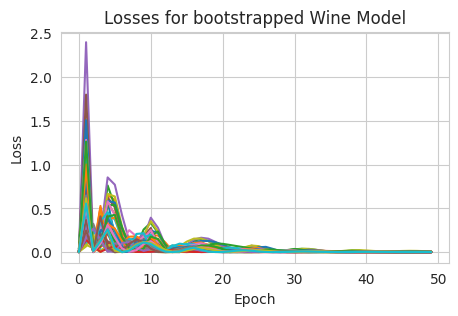

In [244]:
_ = pd.DataFrame(losses_wine).transpose().plot(legend = False, xlabel = "Epoch", ylabel = "Loss", title = "Losses for bootstrapped Wine Model")

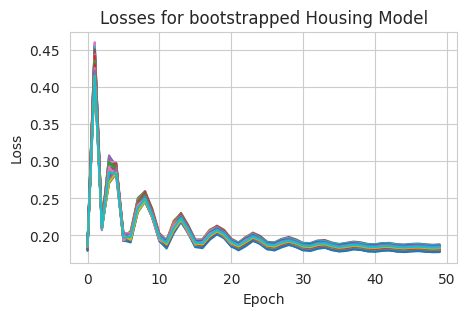

In [245]:
_ = pd.DataFrame(losses_housing).transpose().plot(legend = False, xlabel = "Epoch", ylabel = "Loss", title = "Losses for bootstrapped Housing Model")

Again, learning seemd to converge and now we can take a look at the actual predictions:

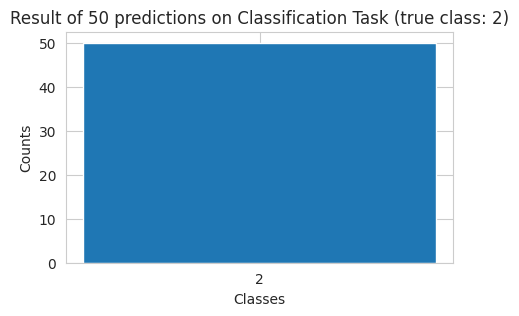

In [246]:
plot_ensemble(losses_wine, predictions_wine, y_test_wine, classification = True)

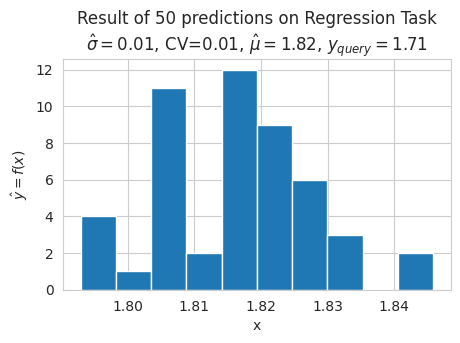

In [247]:
plot_ensemble(losses_housing, predictions_housing, y_test_housing, classification = False)

Now for our classification task we have no disagreement at all between our models and we can also see that for the regression task the predicted mean $\hat{\mu}$ is actually quite close to the actual query value. Note also that the overall dispersion in terms of coefficient of variation (CV) did decline.